# Data scrapping from the Web

In this notebook, we scrape the plot summaries and the box office revenue information from Wikipedia. 

Approximately 40% of film summaries and over 90% of box office values are missing, and these metrics are essential for our analysis. 

To fill these gaps, we use libraries like wikipedia-api and pywikibot, and in cases requiring more detail, we utilize requests and BeautifulSoup for web scraping. Our approach involves extracting summaries from the Plot/Synopsis/Summary sections and box office revenue from the InfoBox, ensuring we access the correct page by handling title variations, such as adding "(film), and handling page redirections.

This process enriches our data, specifically targeting films with incomplete summaries (replacing those under 200 words with the Wikipedia entry) and adding missing box office values.

In [1]:
import pandas as pd
import json
import wikipediaapi
import pywikibot
import matplotlib.pyplot as plt
import numpy as np
import requests
from bs4 import BeautifulSoup
from concurrent.futures import ThreadPoolExecutor, as_completed
import re

In [2]:
DATA_PATH = "../../../data/our_movie_data.csv"
pd.set_option("max_colwidth", None)

In [3]:
df_movie = pd.read_csv(DATA_PATH)

In [21]:
# Select a smaller sample from our complete dataset to apply the scraping techniques
df_movie_sample_for_scraping = df_movie.head(200)

In [22]:
# Select a smaller sample from complete dataset to compare against scraped dataset
df_movie_sample_unscraped = df_movie.head(200)

In [23]:
# Initialize a Wikipedia object using the wikipedia-api library, specifying the English language
wiki_object = wikipediaapi.Wikipedia('MovieSummaryExtractor', 'en')

# Initialize a pywikibot Site object for interacting with the English Wikipedia
site = pywikibot.Site("en", "wikipedia")

Functions to verify that the Wikipedia page is a valid film page

In [24]:
# Function to check if a Wikipedia page has a section titled 'Plot', 'Summary', or 'Synopsis'
def has_film_section(film_name):
    page_py = wiki_object.page(film_name)
    if page_py.exists():
    # Try to find the plot, summary, or synopsis section
        for section_title in ["Plot", "Summary", "Synopsis"]:
            section_plot = page_py.section_by_title(section_title)
            if section_plot:  
                return True
        return False
    return False

# Function to verify if a Wikipedia page is a valid film-related page
def is_film_Wiki_page(title):
    page = pywikibot.Page(site, title)
    # Check if the page exists and if it is a redirect
    if page.exists() and page.isRedirectPage():
        page = page.getRedirectTarget() 
        
    if not has_film_section(title):
        # If page doesn't have film-related section, try appending '(film)' to the title and check again
        page = pywikibot.Page(site, f"{title} (film)")
        if page.exists() and page.isRedirectPage():
            page = page.getRedirectTarget()  
            title = title + '(film)' # Update the title to include "(film)"
        if not has_film_section(title):
            return False, title
    else:
        return True, title
    return True, title


Function to extract a Wikipedia summary for a given movie, and update our dataset

In [25]:
def extract_Wiki_summary(movie):
    # First, check if the Wikipedia page exists and if it's a valid film-related page
    validity, title =  is_film_Wiki_page(movie)
    if validity:
        page_py = wiki_object.page(title)
        # Iterate over potential section titles
        for section_title in ["Plot", "Summary", "Synopsis"]:
            section_plot = page_py.section_by_title(section_title)
            if section_plot:  
                return section_plot.text.strip()
        return None
    return None

In [26]:
def update_summary(row):
    #Convert the entry in 'summary' to a string if it's not NaN, otherwise set it to an empty string
    row['summary'] = str(row['summary']) if pd.notna(row['summary']) else ''

    #Count the number of words in the 'summary' string
    word_count = len(row['summary'].split())
        
    # If the original summary is too short, scrape the Wikipedia plot summary
    if word_count < 200:
        wikipedia_summary = extract_Wiki_summary(row['Movie_name'])  

        # If a Wikipedia summary is found, compare the length of the current summary and Wikipedia summary
        if (wikipedia_summary):
            # If Wikipedia summary is longer, replace the original summary in the dataset
            if len(wikipedia_summary.split()) > word_count:
                return wikipedia_summary
            else:
                return row['summary']
        else:
            return row['summary']
    return row['summary']

In [27]:
# Update the summaries with scraping from Wikipedia
df_movie_sample_for_scraping['summary'] = df_movie_sample_for_scraping.apply(update_summary, axis=1)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movie_sample_for_scraping['summary'] = df_movie_sample_for_scraping.apply(update_summary, axis=1)



Text(0.5, 1.0, 'Distribution of the length of the summary before scraping')

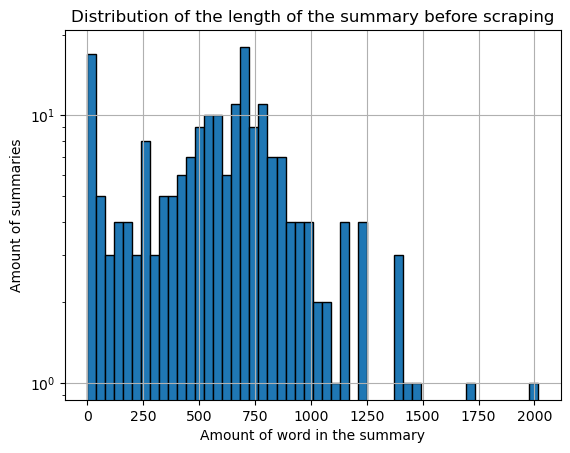

In [28]:
# Plot the distribution of the length of the summaries before scraping
df_plot_length_unscraped = df_movie_sample_unscraped['summary'].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)
df_plot_length_unscraped.hist(bins=50, edgecolor='black')
plt.yscale('log')
plt.xlabel('Amount of word in the summary')
plt.ylabel('Amount of summaries')
plt.title('Distribution of the length of the summary before scraping')

Text(0.5, 1.0, 'Distribution of the length of the summary after scrapping')

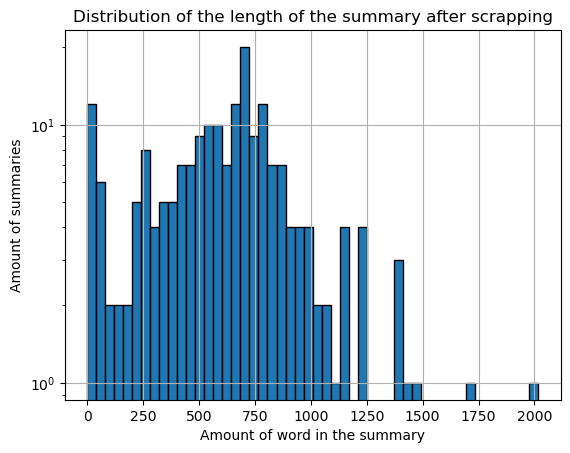

In [29]:
# Plot the distribution of the length of the summaries after scraping
df_plot_length_scraped = df_movie_sample_for_scraping['summary'].apply( lambda x: len(str(x).split()) if pd.notna(x) else 0)
df_plot_length_scraped.hist(bins=50, edgecolor='black')
plt.yscale('log')
plt.xlabel('Amount of word in the summary')
plt.ylabel('Amount of summaries')
plt.title('Distribution of the length of the summary after scrapping')

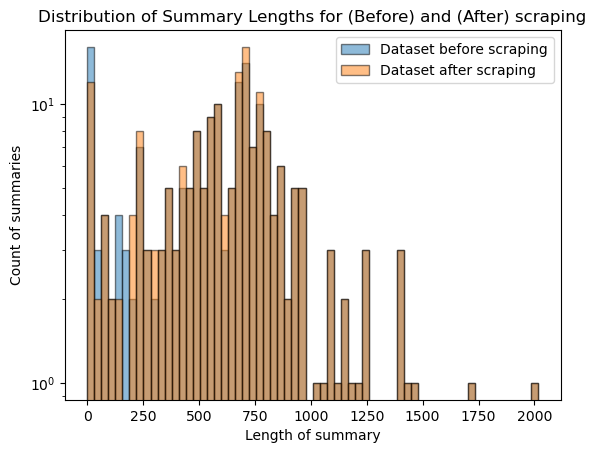

In [30]:
# Calculate the common range for both datasets, before and after scraping
min_val = min(df_plot_length_unscraped.min(), df_plot_length_scraped.min())  
max_val = max(df_plot_length_unscraped.max(), df_plot_length_scraped.max()) 

# Define the bin edges based on the common range 
bin_edges = np.linspace(min_val, max_val, 65)  

# Plot histograms 
plt.hist(df_plot_length_unscraped, bins=bin_edges, edgecolor='black', alpha=0.5, label='Dataset before scraping')
plt.hist(df_plot_length_scraped, bins=bin_edges, edgecolor='black', alpha=0.5, label='Dataset after scraping')

# Set a logarithmic scale for the y-axis
plt.yscale('log')

# Add labels, title, and legend
plt.xlabel('Length of summary')
plt.ylabel('Count of summaries')
plt.title('Distribution of Summary Lengths for (Before) and (After) scraping')
plt.legend()

# Show the plot
plt.show()

When comparing the two distributions of summary lengths, we observe that after scraping, there is an increase in the number of longer summaries, subsequently accompanied by a decrease in the number of shorter ones. This shift is further balanced by the fact that some previously missing summaries (NaN values) have now been populated.

In [31]:
# Calculate word counts for unscraped datasets
df_movie_sample_unscraped.loc[:, 'word_count'] = df_movie_sample_unscraped['summary'].apply(
    lambda x: len(str(x).split()) if pd.notna(x) else 0)

# Calculate word counts for scraped dataset
df_movie_sample_for_scraping.loc[:, 'word_count'] = df_movie_sample_for_scraping['summary'].apply(
    lambda x: len(str(x).split()) if pd.notna(x) else 0)

# Calculate the differences in word counts 
word_count_diff = df_movie_sample_for_scraping['word_count'] - df_movie_sample_unscraped['word_count']

# Calculate the average and standard deviation of the differences
average_difference = word_count_diff.mean()
std_dev_difference = word_count_diff.std()

# Print the results
print(f"Average difference in word count: {average_difference:.2f}")
print(f"Standard deviation of the difference: {std_dev_difference:.2f}")


# Filter rows with 200 words or less
filtered_rows = df_movie_sample_unscraped[df_movie_sample_unscraped['word_count'] <= 200]

# Calculate percentage
percentage = (len(filtered_rows) / len(df_movie_sample_unscraped)) * 100

print(f"Percentage of rows with summaries of 200 words or less: {percentage:.2f}%")

Average difference in word count: 19.90
Standard deviation of the difference: 98.21
Percentage of rows with summaries of 200 words or less: 16.50%


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movie_sample_unscraped.loc[:, 'word_count'] = df_movie_sample_unscraped['summary'].apply(

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movie_sample_for_scraping.loc[:, 'word_count'] = df_movie_sample_for_scraping['summary'].apply(



In [32]:
# Count how many rows in scraped dataset are shorter than the corresponding rows in unscraped dataset
shorter_in_scraped_dataset = (word_count_diff < 0).sum()
longer_in_scraped_dataset = (word_count_diff > 0).sum()

max_longer = word_count_diff.max()
print(f"Max diff in word count: {max_longer:.2f}")

min_longer = word_count_diff.min()
print(f"Min diff in word count: {min_longer:.2f}")

total_rows = len(word_count_diff)

# Calculate the percentage
percentage_shorter_in_df2 = (shorter_in_scraped_dataset / total_rows) * 100
print(f"Percentage of rows where scraped dataset has fewer words than unscraped dataset: {percentage_shorter_in_df2:.2f}%")

percentage_longer_in_df2 = (longer_in_scraped_dataset / total_rows) * 100
print(f"Percentage of rows where scraped dataset has more words than unscraped dataset: {percentage_longer_in_df2:.2f}%")


Max diff in word count: 627.00
Min diff in word count: 0.00
Percentage of rows where scraped dataset has fewer words than unscraped dataset: 0.00%
Percentage of rows where scraped dataset has more words than unscraped dataset: 6.00%


Scraping to get Box office revenue using requests and Beautifulsoup

In [33]:
# Function to retrieve box office revenue from a movie's Wikipedia page
def get_box_office_from_wikipedia(row):
    title = row["Movie_name"]

    # Check if box office revenue is missing in the row
    if pd.isna(row["Movie_box_office_revenue"]): 

        if not isinstance(title, str) or title.strip() == '':
            return None
        
        # Check if the movie title corresponds to a valid Wikipedia page
        validity, title = is_film_Wiki_page(title)

        if validity:
            url = f'https://en.wikipedia.org/wiki/{title}'

            # Send a GET request to fetch the page content
            try:
                response = requests.get(url)
                response.raise_for_status()
            except requests.RequestException as e:
                print(f"Request failed for {title}: {e}")
                return None
            
            # Parse the response HTML using BeautifulSoup
            soup = BeautifulSoup(response.text, 'html.parser')
            infobox = soup.find('table', {'class': 'infobox'})
            if infobox is None:
                return None
            
            box_office = None

            # Iterate through the rows in the infobox table to find box office information
            for row in infobox.find_all('tr'):
                header = row.find('th', {'scope': 'row'})
                if header and header.text.strip() in ['Box office', 'Revenue', 'Gross']:
                    box_office = row.find('td').text.strip()
                    box_office = re.sub(r'\[\d+\]', '', box_office).strip()
                    break
            
            return box_office
        return None
    else:
        return row["Movie_box_office_revenue"]

# Function to fetch box office data for multiple movie titles in parallel
def fetch_box_office_data(titles):
    results = {}
    with ThreadPoolExecutor(max_workers=10) as executor:
        future_to_title = {executor.submit(get_box_office_from_wikipedia, title): title for title in titles}
        for future in as_completed(future_to_title):
            title = future_to_title[future]
            try:
                results[title] = future.result()
            except Exception as exc:
                print(f"Error fetching data for {title}: {exc}")
                results[title] = None
    return results


In [34]:
# Apply box office scraping method to the sample dataset
df_movie_sample_for_scraping["Movie_box_office_revenue"]= df_movie_sample_for_scraping.apply(get_box_office_from_wikipedia, axis=1)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movie_sample_for_scraping["Movie_box_office_revenue"]= df_movie_sample_for_scraping.apply(get_box_office_from_wikipedia, axis=1)



For a sample of 2000 movies, we count 25 minutes of running time

In [98]:
print("The percentage of missing values in the Box office revenue category before scraping is:")
print(df_movie_sample_unscraped["Movie_box_office_revenue"].isna().sum() / len(df_movie_sample_unscraped) * 100)
print("The percent age of missing values in the Box office revenue category after scraping is:")
print(df_movie_sample_for_scraping["Movie_box_office_revenue"].isna().sum() / len(df_movie_sample_for_scraping)*100)

The percentage of missing values in the Box office revenue category before scraping is:
49.65
The percent age of missing values in the Box office revenue category after scraping is:
36.4


### Plot the results

Plot the percentage of missing values in the Box office revenue category, for a sample of 2000 values, before and after scraping

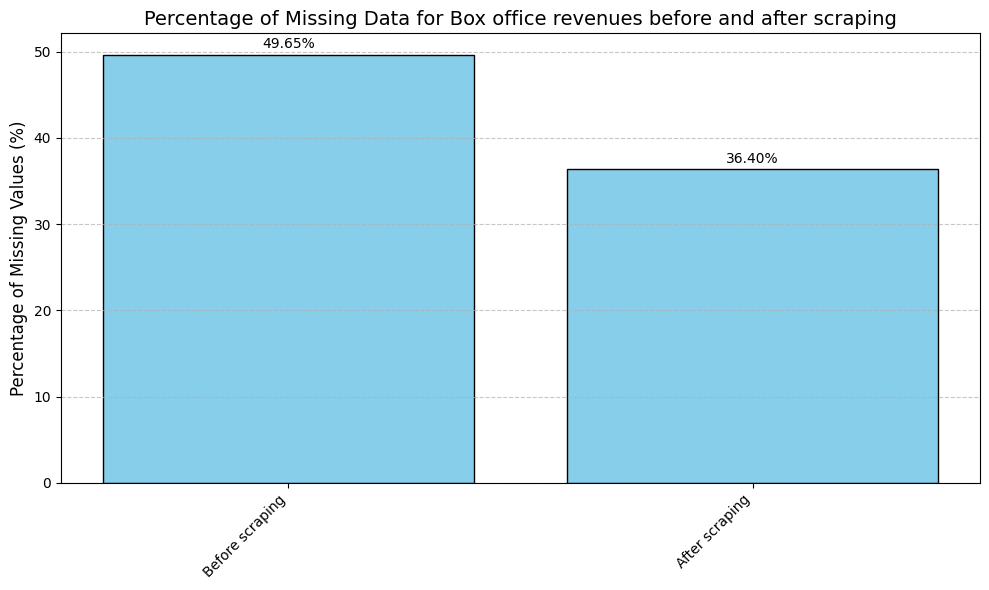

In [100]:
# Calculate the percentage of missing values in the Box office revenue category, for a sample of 2000 values of the dataset
missing_values_before_scraping = df_movie_sample_unscraped["Movie_box_office_revenue"].isna().sum() / len(df_movie_sample_unscraped) * 100
missing_values_after_scraping = df_movie_sample_for_scraping["Movie_box_office_revenue"].isna().sum() / len(df_movie_sample_for_scraping) * 100

# Plot the filtered missing values as a bar chart
plt.figure(figsize=(10, 6))

plt.bar(['Before scraping', 'After scraping'], [missing_values_before_scraping, missing_values_after_scraping],color='skyblue', edgecolor='black')


plt.title('Percentage of Missing Data for Box office revenues before and after scraping', fontsize=14)
plt.ylabel('Percentage of Missing Values (%)', fontsize=12)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the percentage value above each bar
for i, value in enumerate([missing_values_before_scraping, missing_values_after_scraping]):
    plt.text(i, value + 0.4, f'{value:.2f}%', ha='center', va='bottom', fontsize=10)


plt.tight_layout()
plt.show()

We observe that after scraping, on our sample of 2000 elements, we reduce the number of missing values in the Box office revenue category by more than 25%.